In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# the simulator
import simulator

# ephys extraction utilities
from ephys_utils_hh import get_time_voltage_current_currindex0, calculate_summary_statistics, syn_current

#sbi utils
import sbi.utils as utils

# load and read nwb files
from pynwb import NWBHDF5IO

# import saver utilities
import pickle

# to check how long things take
import time

In [4]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Loading observed experimental data

In [5]:
M1_25degree = pickle.load(open('data/M1_features.pickle', 'rb'))
ephys_features = np.array(M1_25degree['X_o'].columns)[:-4]
Xo = M1_25degree['X_o'].copy()

In [6]:
prop = pd.read_csv('data/m1_patchseq_meta_data.csv', sep = '\t')
prop = prop.rename(columns = {'Targeted layer': 'Layer'})
prop = prop[['Cell', 'Layer', 'Cre', 'RNA type']]
prop = prop.set_index('Cell')
prop=prop.reindex(Xo.index)
no_low_qual=np.array(list(map(str,prop['RNA type'].values)))!='nan'
prop=prop.loc[no_low_qual,:]
Xo = Xo.loc[no_low_qual,:]
celltypes=prop['RNA type']

## The uniform prior

In [9]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min),
    high=torch.as_tensor(prior_max)
)

## The simulator

In [10]:
from simulator import EphysModel

In [11]:
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=1,
                   noise_factor=10,
                   use_pathos=False,
                   chunk_size=1000,
                   save_chunks=False)

Let us have a look at two examples.

In [12]:
trial=np.array([9.537584,272.991610,21.443249,93.058479,36.266320,10.740511,0.880451,27.365699,
                0.912325,-85.184921,413.258078,-54.367571,1.655731], dtype=float)[np.newaxis,:]
x=M1_model._run_HH_model(trial)

Text(0, 0.5, 'mV')

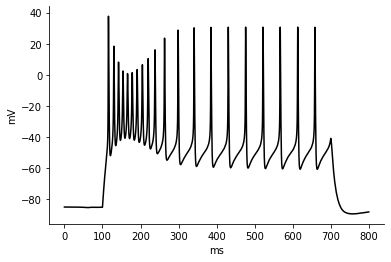

In [13]:
plt.plot(x['time'], x['data'][0,0,:], c='k')
plt.xlabel('ms')
plt.ylabel('mV')

In [14]:
df=pd.DataFrame(data=M1_model._simulation_wrapper(trial).numpy(), columns=ephys_features)
df.head()

,AP threshold,AP amplitude,AP width,AHP,3rd AP threshold,3rd AP amplitude,3rd AP width,3rd AHP,AP count,AP count 1st 8th,...,AP amp adapt,AP average amp adapt,AP CV,ISI adapt,ISI CV,latency,rest $V_{m}$ mean,$V_{m}$ mean,$V_{m}$ std,$V_{m}$ skewness
0,-51.822882,89.584034,2.0,-0.268987,-41.307896,49.57993,2.56,-0.983748,3.135494,2.197225,...,-0.356495,0.435438,-1.449348,-0.17185,-0.649021,2.447551,-85.317931,-43.961633,293.322523,2.115607


Let's try out a randomly sampled one from our uniform prior. It could be a simulation with no action potentials and/or look quite weird!

In [15]:
trial=prior.sample((1,))
df=pd.DataFrame(data=trial,columns=model_param_names)
x=M1_model._run_HH_model(trial)
df.head()

,C,$R_{input}$,$\tau$,$g_{Nat}$,$g_{Na}$,$g_{Kd}$,$g_{M}$,$g_{Kv31}$,$g_{L}$,$E_{leak}$,$\tau_{max}$,VT,rate_to_SS_factor
0,11.971058,927.447815,22.303003,248.034592,70.069847,9.396482,0.816918,51.381664,0.95047,-60.968239,3311.602051,-80.627502,1.536211


Text(0, 0.5, 'mV')

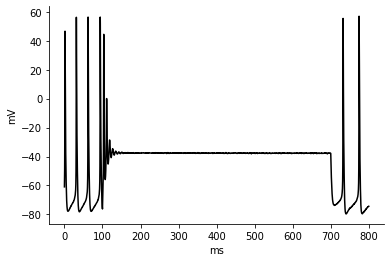

In [16]:
plt.plot(x['time'], x['data'][0,0,:], c='k')
plt.xlabel('ms')
plt.ylabel('mV')

In [17]:
df=pd.DataFrame(data=M1_model._simulation_wrapper(trial).numpy(), columns=ephys_features)
df.head()

,AP threshold,AP amplitude,AP width,AHP,3rd AP threshold,3rd AP amplitude,3rd AP width,3rd AHP,AP count,AP count 1st 8th,...,AP amp adapt,AP average amp adapt,AP CV,ISI adapt,ISI CV,latency,rest $V_{m}$ mean,$V_{m}$ mean,$V_{m}$ std,$V_{m}$ skewness
0,-77.064876,123.867623,1.56,21.105539,NaN,NaN,NaN,NaN,1.609438,1.609438,...,-0.855278,3.293214e-13,-0.90796,NaN,NaN,-1.021651,-62.748288,-37.567835,17.73479,8.68977


## Distribution of summary statistics

Let us have a look at the distribion of simulated summary statistics (or ephys features) versus the distribution of summary statistics of our observed experimental dataset.

In [18]:
# In our visualizations of 1-dimensional ephys feature distributions,
# we'll keep the ones within certain limits to prevent outliers in the visualization.
limits={'AP threshold':[-120,75], 'AP amplitude':[0,200], 'AP width':[0,5], 'AHP':[-80,50], \
        '3rd AP threshold':[-100,100], '3rd AP amplitude':[0,200], '3rd AP width':[0,5], '3rd AHP':[-60,30], \
        'AP count':[0,400], 'AP count 1st 8th': [0,135], 'AP count 1st quarter': [0,180], \
        'AP count 1st half':[0,200], 'AP count 2nd half':[0,200], 'AP amp adapt':[-1.5,1.5], \
        'AP average amp adapt':[-0.1,1.1], 'AP CV':[-7.5,0], \
        'ISI adapt':[-3,3], 'ISI CV':[-8,2.5], 'latency':[-2,6.5], r'rest $V_{m}$ mean':[-120,100], \
        r'$V_{m}$ mean':[-110,50], r'$V_{m}$ std':[0,2000], r'$V_{m}$ skewness':[-2,12], \
        'Vi':[-150,-40], '1-comp area':[0,4000]}

tcmalloc: large alloc 1380007936 bytes == 0x3b440000 @ 


(# sims, # ephys features):  (15000000, 23)
and after deleting Nan and Inf simulations: 
(# sims, # ephys features):  (7155552, 23)


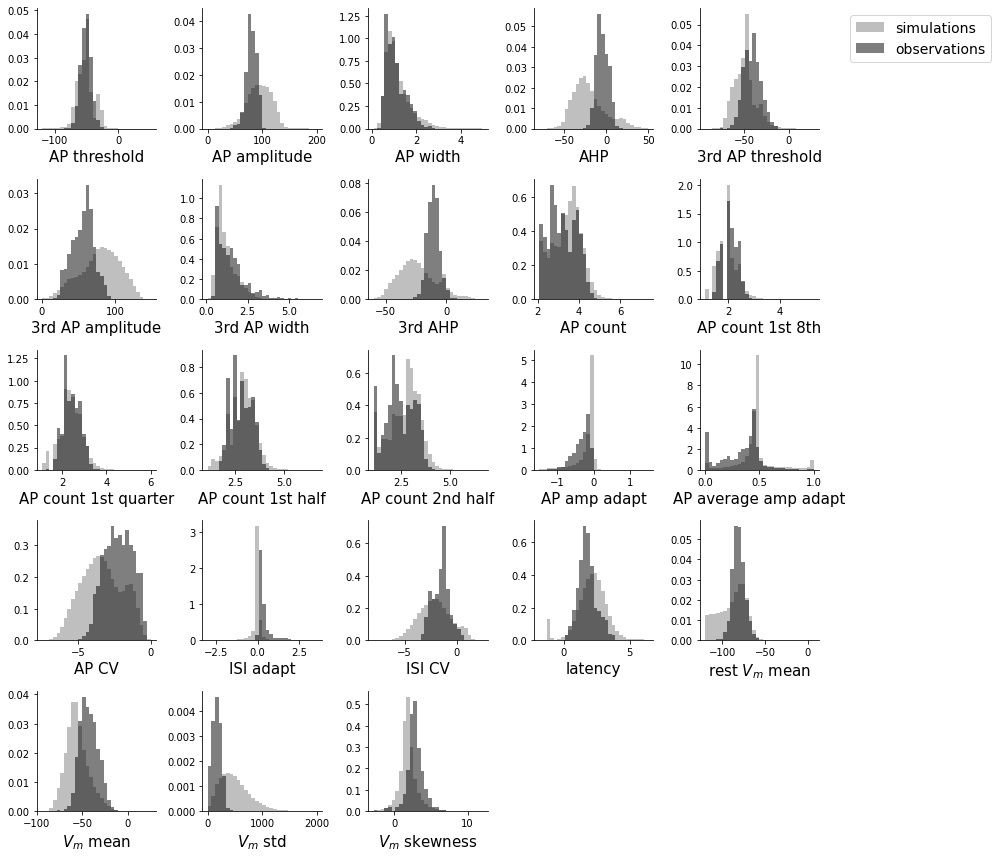

In [34]:
theta=np.load('data/full_batch.npz')['theta']
stats=np.load('data/full_batch.npz')['stats']
print('(# sims, # ephys features): ', stats.shape)
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping,:] # delete Nan simulations
print('and after deleting Nan and Inf simulations: \n(# sims, # ephys features): ', stats.shape)

fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[:len(ephys_features)]):
        ax.hist([Xo[ephys_features[i]].values,
                 stats[:,i][(stats[:,i]>limits[ephys_features[i]][0])&\
                            (stats[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))

for ax in axes.reshape(-1)[len(ephys_features):]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

Most summary statistics of our experimental dataset (observations) are very nicely covered by our simulations. Yet, we can observe some level of 'data-model gap' in terms of some 'harder to fit' summary statistics, such as the ISI adapt.

## Best prior simulations for an observed cell

Pick a cell. You can for instance check `Xo.index` and pick one.

In [25]:
Xo.index

Index(['20190418_sample_8', '20190418_sample_5', '20190418_sample_2',
       '20190418_sample_9', '20190418_sample_10', '20191108_sample_5',
       '20191108_sample_1', '20190327_sample_4', '20190327_sample_2',
       '20180828_sample_3',
       ...
       '20190424_sample_4', '20180208_sample_4', '20180208_sample_3',
       '20180208_sample_2', '20180208_sample_5', '20200106_sample_1',
       '20200106_sample_5', '20190704_sample_12', '20190704_sample_14',
       '20190718_sample_2'],
      dtype='object', name='cell id', length=955)

In [58]:
cell_name = '20190604_sample_2' # fast-spiking Pvalb Kank4

In [68]:
cell_name = '20181127_sample_4' # Sst Hpse

In [76]:
cell_name = '20180529_sample_3' # L4/5 IT_1

In [77]:
#Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree['M1_names'])[no_low_qual][np.where(Xo.index==cell_name)[0][0]]
data

'../data/raw_data/000008/sub-mouse-PAIFP/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb'

In [78]:
data = './data/raw_data/'+data.split('/')[-1]

In [79]:
data

'./data/raw_data/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb'

In [80]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, 'r', load_namespaces=True).read()

In [81]:
xo=Xo.loc[cell_name,:].iloc[:-4].values
feature_list=range(23)

In [82]:
time_obs, voltage_obs, current_obs, curr_index_0_obs = get_time_voltage_current_currindex0(data)
liquid_junction_potential=15.4
voltage_obs-=liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(area=Xo.loc[cell_name, '1-comp area'], curr_level=3e-4)
curr_index = np.where(current_obs==300)[0][0]
observation = {'data': voltage_obs[:20000, curr_index], 'time': time_obs[:20000]*1e3, 'dt':4*1e-5*1e3, 'I': I}

In [37]:
theta=np.load('data/full_batch.npz')['theta']
stats=np.load('data/full_batch.npz')['stats']
print('(# sims, # ephys features): ', stats.shape)
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping,:] # delete Nan simulations
print('and after deleting Nan and Inf simulations: \n(# sims, # ephys features): ', stats.shape)

(# sims, # ephys features):  (15000000, 23)
and after deleting Nan and Inf simulations: 
(# sims, # ephys features):  (7155552, 23)


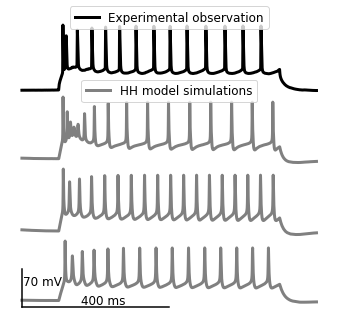

In [83]:
lw=3

# Best Euclidean examples now for an example
fig=plt.figure(figsize=(5,5))
width=.9
height=.2
ax_truth=plt.axes([0,0.6,width,height])
ax_sim1=plt.axes([0,0.4,width,height])
ax_sim2=plt.axes([0,.2,width,height])
ax_sim3=plt.axes([0,0,width,height])

# plot observation
ax_truth.plot(observation['time'], observation['data'], lw=lw, label='Experimental observation', c='k')
ax_truth.legend(loc='upper center', bbox_to_anchor=(.5,1.3), fontsize=12)
ax_truth.set_xticks([])
ax_truth.set_yticks([])
sns.despine(ax=ax_truth, bottom=True,left=True)

#3. pick 3 that have the smallest Euclidean distance of their summ stats with the experimental observation
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
ind=np.argsort(np.sum(
                np.square((stats[:,feature_list]-s_mean)/s_std
                    -(xo[feature_list]-s_mean)/s_std
                         ),
                axis=1
                    )
              )[0:3]
#4. show those 3 simulations
x = M1_model._run_HH_model(theta[keeping,:][ind,:])
ax_sim1.plot(x['time'], x['data'][0,0,:], lw=lw, c='grey', label='HH model simulations')
ax_sim2.plot(x['time'], x['data'][1,0,:], lw=lw, c='grey')
ax_sim3.plot(x['time'], x['data'][2,0,:], lw=lw, c='grey')
ax_sim3.plot([0,400], [-100,-100], 'k')
ax_sim3.annotate('400 ms', (160,-96), fontsize=12)
ax_sim3.plot([0,0], [-100,-30], 'k')
ax_sim3.annotate('70 mV', (3,-60), fontsize=12)
# ax_sim3.set_xlabel('Time (ms)', fontsize=10)
# ax_sim3.set_ylabel('Voltage (mV)', fontsize=10)
ax_sim1.legend(loc='upper center', bbox_to_anchor=(.5,1.28), fontsize=12)
for ax in [ax_truth, ax_sim1, ax_sim2, ax_sim3]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True,left=True)
plt.savefig('./figures/{}.pdf'.format(cell_name))

In [48]:
df=pd.DataFrame(data=theta[keeping,:][ind,:], columns=model_param_names)
df

,C,$R_{input}$,$\tau$,$g_{Nat}$,$g_{Na}$,$g_{Kd}$,$g_{M}$,$g_{Kv31}$,$g_{L}$,$E_{leak}$,$\tau_{max}$,VT,rate_to_SS_factor
0,8.475982,579.392456,43.844521,112.609238,42.605244,11.546332,2.671538,99.308281,2.064796,-84.977928,385.326141,-65.207230,1.691576
1,12.480132,759.174622,67.508606,77.595337,37.895184,14.374455,2.839350,143.901672,2.294485,-80.633545,116.753838,-66.564301,1.846007
2,12.196687,569.508057,64.445389,105.307953,20.574211,15.574615,2.803297,109.506355,2.647254,-88.307648,210.423447,-70.096146,1.636666
